Imports and Helper Functions

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model
from keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K


import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import librosa as lr

import sklearn
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


# directories 
MetaDataDir = "./02_Data/0001_Database.xlsx"
WeldDir = "./02_Data/02_Weldqas"
AudioDir = "./02_Data/01_Audio"

# helper functions 
def short_fourier_feature_extraction_welding(path):
    try:
        df = pd.read_csv(path)
        fs = 1 / np.mean(np.diff(df["Time [s]"]))
        df = df.drop(columns=["Time [s]", "Wire [m/min]"], errors="ignore")
    except Exception as e:
        print(f"Fehler beim Laden der Datei {path}: {e}")
        return None
    
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.empty:
        return None

    frequency_features = []

    for col in numeric_df.columns:
        series = numeric_df[col].dropna().values
        series = series - np.mean(series)  # optional: zentrieren
        
        # STFT über librosa
        n_fft = int(0.256 * fs)
        hop_length = n_fft // 4
        n_mels = int(min(128, fs // 62.5))  # z. B. ~32 Bins pro kHz

        # Mel-Spectrogram (Librosa macht STFT intern)
        mel_spec = lr.feature.melspectrogram(
            y=series,
            sr=fs,
            n_fft=512,
            hop_length=hop_length,
            n_mels=n_mels,
            power=2.0
        )

        # Feature aus log-Mel-Spektrum
        frequency_features.extend([
            mel_spec.mean(),
            mel_spec.std(),
            mel_spec.min(),
            mel_spec.max(),
            mel_spec.var(),
            skew(mel_spec.flatten()),
            kurtosis(mel_spec.flatten()),
        ])

        centroid = lr.feature.spectral_centroid(y=series, sr=fs)[0]
        frequency_features.extend([
        centroid.mean(),
        centroid.std()
        ])

    return frequency_features

def extract_features_from_welding(path):
    try:
        df = pd.read_csv(path)
        df = df.drop(columns=["Time [s]", "Wire [m/min]"])
    except Exception as e:
        print(f"Fehler beim Laden der Datei {path}: {e}")
        return None

    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.empty:
        return None

    features = []
    for col in numeric_df.columns:
        series = numeric_df[col]
        features.extend([
            series.mean(),
            series.std(),
            series.min(),
            series.max(),
            series.skew(),
            series.kurt(),
        ])
    return features

def short_fourier_feature_extraction_audio(path):
    try:
        df = pd.read_csv(path, index_col=0)  # erste Spalte (Index) nicht als Daten lesen
        fs = 1 / np.mean(np.diff(df["Time"]))
        df = df.drop(columns=["Time"], errors="ignore")
    except Exception as e:
        print(f"Fehler beim Laden der Datei {path}: {e}")
        return None
    
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.empty:
        return None

    frequency_features = []

    for col in numeric_df.columns:
        series = numeric_df[col].dropna().values
        series = series - np.mean(series)  #zentrieren
        
        # STFT über librosa
        n_fft = int(0.256 * fs)
        hop_length = n_fft // 4
        n_mels = int(min(128, fs // 62.5)) 

        # Mel-Spectrogram (Librosa macht STFT intern)
        mel_spec = lr.feature.melspectrogram(
            y=series,
            sr=fs,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            power=2.0
        )

        # Feature aus Mel-Spektrum
        frequency_features.extend([
            mel_spec.mean(),
            mel_spec.std(),
            mel_spec.min(),
            mel_spec.max(),
            mel_spec.var(),
            skew(mel_spec.flatten()),
            kurtosis(mel_spec.flatten()),
        ])

        centroid = lr.feature.spectral_centroid(y=series, sr=fs)[0]
        frequency_features.extend([
        centroid.mean(),
        centroid.std()
        ])

    return frequency_features

def extract_features_from_audio(path):
    try:
        df = pd.read_csv(path, index_col=0)  # erste Spalte (Index) nicht als Daten lesen
        df = df.drop(columns=["Time"], errors="ignore")
    except Exception as e:
        print(f"Fehler beim Laden der Datei {path}: {e}")
        return None

    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.empty:
        return None

    features = []
    for col in numeric_df.columns:
        series = numeric_df[col]
        features.extend([
            series.mean(),
            series.std(),
            series.min(),
            series.max(),
            series.skew(),
            series.kurt(),
        ])
    return features

def plot_final_model(history, cm_val, cm_test): 

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Trainingsverlauf: Accuracy und Loss', fontsize=16)

    # Accuracy-Verlauf
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', color='skyblue')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss-Verlauf
    axes[1].plot(history.history['loss'], label='Train Loss', color='red')
    axes[1].plot(history.history['val_loss'], label='Val Loss', color='orange')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Confusion Matrices: Validation vs. Test', fontsize=16)

    # Validation CM
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=["iO", "oil", "offset", "tilt"])
    disp1.plot(ax=axes[0], colorbar=True)
    axes[0].set_title("Validation Data")

    # Test CM
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["iO", "oil", "offset", "tilt"])
    disp2.plot(ax=axes[1], colorbar=True)
    axes[1].set_title("Test Data")

    plt.tight_layout()
    plt.show()

def plot_cross_validation_summary(train_accuracies, val_accuracies,test_accuracies, all_y_pred_test,
                                  all_y_true, all_y_pred, class_names):
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle("MLP Cross-Validation Summary", fontsize=16)

    # 2. Accuracy per Fold
    ax2 = plt.subplot2grid((2, 2), (0, 0))
    ax2.plot(train_accuracies, label='Train Accuracy', marker='o')
    ax2.plot(val_accuracies, label='Val Accuracy', marker='o')
    ax2.plot(test_accuracies, label='Test Accuracy', marker='o')
    overfit = [a - b for a, b in zip(train_accuracies, val_accuracies)]
    ax2.plot(overfit, label='Overfitting', linestyle='--', marker='x')
    ax2.set_title("Accuracies Across Folds")
    ax2.set_xlabel("Fold Index")
    ax2.grid(True)
    ax2.legend()

    # 3. Bar Plot of Mean Accuracies
    ax3 = plt.subplot2grid((2, 2), (0, 1))
    categories = ['Training\nAccuracy', 'Validation\nAccuracy', 'Test\nAccuracy']
    accuracies = [np.mean(train_accuracies), np.mean(val_accuracies), np.mean(test_accuracies)]
    colors = ['lightblue', 'lightcoral', 'lightgreen']

    bars = ax3.bar(categories, accuracies, color=colors, alpha=0.8, edgecolor='black')

    for bar, acc in zip(bars, accuracies):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
        f'{acc:.3f}\n({acc*100:.1f}%)', ha='center', va='bottom', fontweight='bold')
    ax3.set_ylabel('Accuracy')
    ax3.set_ylim(0, 1.1)
    ax3.set_title('Accuracy Summary')
    ax3.grid(True)

    # 4. Confusion Matrix
    ax4 = plt.subplot2grid((2, 2), (1, 0))
    cm = confusion_matrix(all_y_true, all_y_pred)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax4, cmap=plt.cm.Blues)
    ax4.set_title("Confusion Matrix on Validation Data")

    ax5 = plt.subplot2grid((2, 2), (1, 1))
    cm = confusion_matrix(all_y_test, all_y_pred_test)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax5, cmap=plt.cm.Blues)
    ax5.set_title("Confusion Matrix on Test Data")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

Data preparation and extraction 

In [2]:
file = tf.keras.utils
# load Excel
meta_df = pd.read_excel("./02_Data/0001_Database.xlsx", sheet_name="Database", skiprows=10)
# only use data marked as usable and with iO/niO labels
meta_df = meta_df[meta_df["Usable"] == "Yes"]
meta_df = meta_df[meta_df["Dataset"].isin(["iO", "niO"])]
#meta_df = meta_df[meta_df["Audio"] == "Yes"]
#labeling error io and nio based on error type in forceed error column 
meta_df["label"] = meta_df["Forced Error Type"].map({"iO": 0, "oil": 1, "offset": 2, "Tilt": 3})
# Add file column based on "Number of Measurement"
meta_df["file"] = meta_df["Number of Measurement"].astype(str) + ".csv"

meta_df = meta_df[["Number of Measurement", "file", "label", "Dataset", "Audio", "Forced Error Type"]]

# imbalance check 
io, oil, offset, tilt = np.bincount(meta_df['label'])
total = io + offset + oil + tilt
print('Imbalance Check:\nSamples:\n    Total: {}\n    iO: {} ({:.2f}% of total)\n    oil: {} ({:.2f}% of total)\n    tilt: {} ({:.2f}% of total)\n    offset: {} ({:.2f}% of total)'.format(
    total, io, 100 * io / total, oil, 100 * oil / total, tilt, 100 * tilt / total, offset, 100 * offset / total))

print("\nMeta Data Head:")
meta_df.head()

Imbalance Check:
Samples:
    Total: 259
    iO: 50 (19.31% of total)
    oil: 50 (19.31% of total)
    tilt: 79 (30.50% of total)
    offset: 80 (30.89% of total)

Meta Data Head:


,Number of Measurement,file,label,Dataset,Audio,Forced Error Type
0,169,169.csv,0,iO,Yes,iO
1,170,170.csv,0,iO,Yes,iO
2,171,171.csv,0,iO,Yes,iO
3,172,172.csv,0,iO,Yes,iO
4,173,173.csv,0,iO,Yes,iO


In [3]:
feature_names_welding_spec = ["Current_mean_spec", "Current_std_spec", "Current_min_spec", "Current_max_spec", "Current_var_spec", "Current_skew_spec", "Current_kurt_spec", "Current_centroid_mean", "Current_centroid_std",
                "Voltage_mean_spec", "Voltage_std_spec", "Voltage_min_spec", "Voltage_max_spec", "Voltage_var_spec", "Voltage_skew_spec", "Voltage_kurt_spec", "Voltage_centroid_mean", "Voltage_centroid_std"]
feature_names_welding = ["Current_mean", "Current_std", "Current_min", "Current_max", "Current_skew", "Current_kurt",
                 "Voltage_mean", "Voltage_std", "Voltage_min", "Voltage_max", "Voltage_skew", "Voltage_kurt"]
feature_names_audio_spec = ["Audio_mean_spec", "Audio_std_spec", "Audio_min_spec", "Audio_max_spec", "Audio_var_spec",
                    "Audio_skew_spec", "Audio_kurt_spec", "Audio_centroid_mean", "Audio_centroid_std"]
feature_names_audio = ["Audio_mean", "Audio_std", "Audio_min", "Audio_max", "Audio_skew", "Audio_kurt"]

feature_names = feature_names_welding + feature_names_welding_spec + feature_names_audio + feature_names_audio_spec


welding_features_list = []
audio_features_list = []
audio_masks = []
labels = []

for _, row in meta_df.iterrows():
    welding_path = os.path.join(WeldDir, row["file"])
    audio_path = os.path.join(AudioDir, row["file"]) if row["Audio"] == "Yes" else None

    f_welding = extract_features_from_welding(welding_path)
    f_welding_spec = short_fourier_feature_extraction_welding(welding_path)
    welding_feat = f_welding + f_welding_spec if f_welding and f_welding_spec else None

    if welding_feat is None:
        continue

    if audio_path and os.path.exists(audio_path):
        f_audio = extract_features_from_audio(audio_path)
        f_audio_spec = short_fourier_feature_extraction_audio(audio_path)
        if f_audio and f_audio_spec:
            audio_feat = f_audio + f_audio_spec
            audio_mask = 1
        else:
            audio_feat = [0.0] * (len(feature_names_audio + feature_names_audio_spec))
            audio_mask = 0
    else:
        audio_feat = [0.0] * (len(feature_names_audio + feature_names_audio_spec))
        audio_mask = 0

    welding_features_list.append(welding_feat)
    audio_features_list.append(audio_feat)
    audio_masks.append([audio_mask])  # shape (n, 1)
    labels.append(row["label"])


X_welding = np.array(welding_features_list)
X_audio = np.array(audio_features_list)
audio_masks = np.array(audio_masks)
y = np.array(labels)


Cross Validation Setup (Only run Code above and this following Cell for CV)


=== Fold 1/8 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

=== Fold 2/8 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

=== Fold 3/8 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

=== Fold 4/8 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

=== Fold 5/8 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

=== Fold 6/8 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

=== Fold 7/8 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

=== Fold 8/8 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


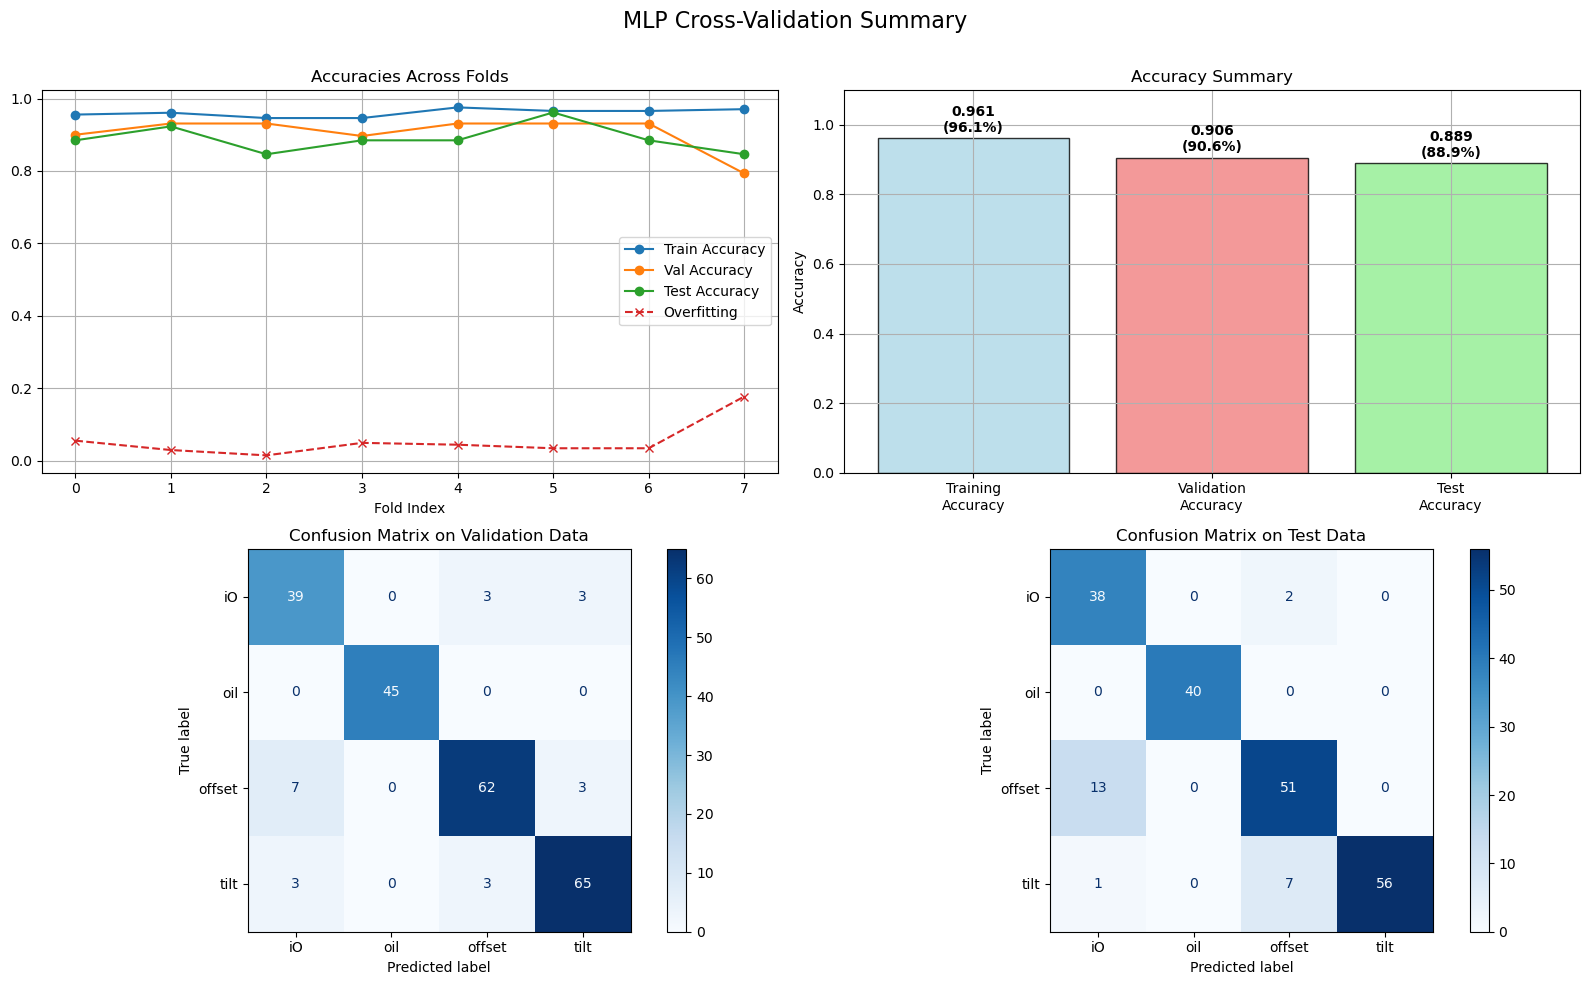


=== Fold 1 Classification Report ===
              precision    recall  f1-score   support

          iO       0.67      1.00      0.80         6
         oil       1.00      1.00      1.00         6
      offset       1.00      0.67      0.80         9
        tilt       1.00      1.00      1.00         9

    accuracy                           0.90        30
   macro avg       0.92      0.92      0.90        30
weighted avg       0.93      0.90      0.90        30


=== Fold 2 Classification Report ===
              precision    recall  f1-score   support

          iO       0.86      1.00      0.92         6
         oil       1.00      1.00      1.00         6
      offset       0.89      0.89      0.89         9
        tilt       1.00      0.88      0.93         8

    accuracy                           0.93        29
   macro avg       0.94      0.94      0.94        29
weighted avg       0.94      0.93      0.93        29


=== Fold 3 Classification Report ===
              pr

In [4]:
#Split of training data and test data
X_welding, Xw_test, X_audio, Xa_test, audio_masks, mask_test, y, y_test = train_test_split(
    X_welding, X_audio, audio_masks, y, test_size=0.1, stratify=y, random_state=42
)

# ======== Cross-Validation Setup =========
n_splits = 8
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
class_names = ["iO", "oil", "offset", "tilt"]

pca_components = 10

train_accuracies = []
val_accuracies = []
all_y_true = []
all_y_pred = []
all_y_test = []
all_y_pred_test = []
test_accuracies = []
pca_welding_all = []
pca_audio_all = []
classification_reports = []


for fold, (train_idx, val_idx) in enumerate(skf.split(X_welding, y)):
    print(f"\n=== Fold {fold + 1}/{n_splits} ===")

    # Split
    Xw_train, Xw_val = X_welding[train_idx], X_welding[val_idx]
    Xa_train, Xa_val = X_audio[train_idx], X_audio[val_idx]
    Xm_train, Xm_val = audio_masks[train_idx], audio_masks[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Skalierung
    scaler_welding = StandardScaler()
    scaler_audio = StandardScaler()

    Xw_train = scaler_welding.fit_transform(Xw_train)
    Xw_val = scaler_welding.transform(Xw_val)

    Xa_train = scaler_audio.fit_transform(Xa_train)
    Xa_val = scaler_audio.transform(Xa_val)

    # PCA
    pca_weld = PCA(n_components=pca_components).fit(Xw_train)
    Xw_train = pca_weld.transform(Xw_train)
    Xw_val = pca_weld.transform(Xw_val)
    pca_welding_all.append(pca_weld.explained_variance_ratio_)

    pca_audio = PCA(n_components=pca_components).fit(Xa_train)
    Xa_train = pca_audio.transform(Xa_train)
    Xa_val = pca_audio.transform(Xa_val)
    pca_audio_all.append(pca_audio.explained_variance_ratio_)

    # Klassengewichte
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    K.clear_session()

    # Modell
    input_welding = Input(shape=(Xw_train.shape[1],), name='welding_input')
    input_audio = Input(shape=(Xa_train.shape[1],), name='audio_input')
    input_mask = Input(shape=(1,), name='audio_mask')

    x1 = layers.Dense(128, activation='relu')(input_welding)
    x1 = layers.Dropout(0.3)(x1)
    x1 = layers.Dense(64, activation='relu')(x1)

    x2 = layers.Dense(128, activation='relu')(input_audio)
    x2 = layers.Dropout(0.3)(x2)
    x2 = layers.Dense(64, activation='relu')(x2)

    x2_masked = layers.Multiply()([x2, input_mask])

    x = layers.Concatenate()([x1, x2_masked])
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.05))(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(4, activation='softmax')(x)

    model = Model(inputs=[input_welding, input_audio, input_mask], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        [Xw_train, Xa_train, Xm_train],
        y_train,
        validation_data=([Xw_val, Xa_val, Xm_val], y_val),
        epochs=50,
        batch_size=32,
        class_weight=class_weights,
        verbose=0
    )

    # Evaluation
    y_pred = model.predict([Xw_val, Xa_val, Xm_val]).argmax(axis=1)

    train_accuracies.append(history.history['accuracy'][-1])
    val_accuracies.append(history.history['val_accuracy'][-1])
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

    classification_reports.append(classification_report(y_val, y_pred, target_names=class_names))

    # Transformieren Testdaten mit fold-spezifischen Scaler und PCA
    Xw_test_scaled = scaler_welding.transform(Xw_test)
    Xw_test_pca = pca_weld.transform(Xw_test_scaled)

    Xa_test_scaled = scaler_audio.transform(Xa_test)
    Xa_test_pca = pca_audio.transform(Xa_test_scaled)

    y_pred_test = model.predict([Xw_test_pca, Xa_test_pca, mask_test]).argmax(axis=1)
    all_y_pred_test.extend(y_pred_test)
    all_y_test.extend(y_test)

    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_accuracies.append(test_accuracy)


# Zusammenfassung plotten
plot_cross_validation_summary(train_accuracies, val_accuracies, test_accuracies, all_y_pred_test, all_y_true, all_y_pred, class_names)

for i, report in enumerate(classification_reports):
    print(f"\n=== Fold {i + 1} Classification Report ===")
    print(report)


Data Split and PCA for final model 

In [ ]:
# Split
Xw_train, Xw_test, Xa_train, Xa_test, mask_train, mask_test, y_train, y_test = train_test_split(
    X_welding, X_audio, audio_masks, y, test_size=0.1, stratify=y, random_state=42
)

Xw_train, Xw_val, Xa_train, Xa_val, mask_train, mask_val, y_train, y_val = train_test_split(
    Xw_train, Xa_train, mask_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Normalisieren
scaler_welding = StandardScaler()
scaler_audio = StandardScaler()

Xw_train = scaler_welding.fit_transform(Xw_train)
Xw_val = scaler_welding.transform(Xw_val)
Xw_test = scaler_welding.transform(Xw_test)

Xa_train = scaler_audio.fit_transform(Xa_train)
Xa_val = scaler_audio.transform(Xa_val)
Xa_test = scaler_audio.transform(Xa_test)


print(f"\nWelding: X_Train shape {Xw_train.shape}, X_Val shape {Xw_val.shape}, X_Test shape {Xw_test.shape}")
print(f"\nAudio: X_Train shape {Xa_train.shape}, X_Val shape {Xa_val.shape}, X_Test shape {Xa_test.shape}")
print(f"\ny_train {y_train.shape}, y_val {y_val.shape}, y_test {y_test.shape}")
print(f"\nAnzahl der Features Welding: {Xw_train.shape[1]}, Anzahl der Features Audio: {Xa_train.shape[1]}, Anzahl der Klassen: {len(np.unique(y_train))}")

# PCA 
pca_weld = PCA(n_components=10).fit(Xw_train)
Xw_train = pca_weld.transform(Xw_train)
Xw_val = pca_weld.transform(Xw_val)
Xw_test = pca_weld.transform(Xw_test)

pca_audio = PCA(n_components=10).fit(Xa_train)
Xa_train = pca_audio.transform(Xa_train)
Xa_val = pca_audio.transform(Xa_val)
Xa_test = pca_audio.transform(Xa_test)


print(f"\nPCA Welding: X_Train shape {Xw_train.shape}, X_Val shape {Xw_val.shape}, X_Test shape {Xw_test.shape}")
print(f"\nPCA Audio: X_Train shape {Xa_train.shape}, X_Val shape {Xa_val.shape}, X_Test shape {Xa_test.shape}")
print(f"\nFinale Anzahl der Features nach PCA Welding: {Xw_train.shape[1]}, Anzahl der Features Audio: {Xa_train.shape[1]}")


Model Creation and Training

In [ ]:
# zwei separate MLP-Zweige für Welding und Audio
# und eine Maske für Audio, die 0 setzt, wenn kein Audio vorhanden ist

# Eingänge
input_welding = Input(shape=(Xw_train.shape[1],), name='welding_input')
input_audio = Input(shape=(Xa_train.shape[1],), name='audio_input')
input_mask = Input(shape=(1,), name='audio_mask')

# Welding-Zweig
x1 = layers.Dense(128, activation='relu')(input_welding)
x1 = layers.Dropout(0.3)(x1)  # Dropout für Regularisierung
x1 = layers.Dense(64, activation='relu')(x1)

# Audio-Zweig
x2 = layers.Dense(128, activation='relu')(input_audio)
x2 = layers.Dropout(0.3)(x2)  # Dropout für Regularisierung
x2 = layers.Dense(64, activation='relu')(x2)

# Maske anwenden
x2_masked = layers.Multiply()([x2, input_mask])  # Setzt Audio auf 0 wenn maske = 0

# Kombinieren
x = layers.Concatenate()([x1, x2_masked])
x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.05))(x)
x = layers.Dropout(0.4)(x)  # Dropout für Regularisierung
output = layers.Dense(4, activation='softmax')(x)

model = Model(inputs=[input_welding, input_audio, input_mask], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

#plot_model(model,to_file="model_architecture.png",show_shapes=True,show_layer_names=True,expand_nested=True, dpi=100)


In [ ]:

#Train and evaluate the model
history = model.fit(
    [Xw_train, Xa_train, mask_train], y_train,
    validation_data=([Xw_val, Xa_val, mask_val], y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights, 
    verbose=0
)

#Validation data
y_pred = model.predict([Xw_val, Xa_val, mask_val]).argmax(axis=1)
print("\nValidation Classification Report:")
print(classification_report(y_val, y_pred, target_names=["iO", "oil", "offset", "tilt"]))
cm_val = confusion_matrix(y_val, y_pred)

# Test data
y_test_pred = model.predict([Xw_test, Xa_test, mask_test]).argmax(axis=1)
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=["iO", "oil", "offset", "tilt"]))
cm_test = confusion_matrix(y_test, y_test_pred)

plot_final_model(history, cm_val, cm_test)

overfitting_rate = np.abs(np.mean(history.history['accuracy']) - np.mean(history.history['val_accuracy']))
orate = np.mean(history.history['accuracy']) - np.mean(history.history['val_accuracy'])
print(f"\nOverfitting Rate: {overfitting_rate:.4f}")
